In [1]:
import os
os.environ['PATH'] = "/home/riascodc/DelftOpenSource/bin:" + os.environ['PATH']

import matplotlib.pyplot as plt
import segyio
import obspy
import pickle 
from matplotlib import colors
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator, CubicSpline
import numpy as np
from matplotlib.colors import Normalize
from numpy.polynomial import Polynomial
import colorcet as cc
from scipy.signal import ricker, convolve, correlate
from celluloid import Camera

path = './Data'
os.system(f'cd {path}')

with open('sources_array.pkl', 'rb') as f:
    sources_dic, t_wav = pickle.load(f)

from scipy.integrate import cumulative_trapezoid

In [2]:
x_model = 80
y_model = 40
dx = 0.25

nx, nz = int(x_model//dx)+1, int(y_model//dx)+1

snap_vz = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_svz.su', endian='little', ignore_geometry=True)
snap_vz = segyio.collect(snap_vz.trace)[:].flatten()

nsnap = snap_vz.size // (nx*nz)
snap_vz = snap_vz.reshape(nsnap, nx, nz)

snap_vx = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/testsnap_svx.su', endian='little', ignore_geometry=True)
snap_vx = segyio.collect(snap_vx.trace)[:].flatten()
snap_vx = snap_vx.reshape(nsnap, nx, nz)

# SNAPSHOT PARAMETERS
tsnap1 = 0.01
tsnap2 = 0.8
dtsnap = 0.001

time = np.arange(0, tsnap2+dtsnap, dtsnap)
time.shape


(801,)

In [3]:
# Integrate over time for each spatial point
disp_x = cumulative_trapezoid(snap_vx, dx=dtsnap, axis=0, initial=0)
disp_z = cumulative_trapezoid(snap_vz, dx=dtsnap, axis=0, initial=0)

disp_z.max(), snap_vz.max(), disp_x.max()

(0.012681118, 0.4895466, 0.0044684014)

In [4]:
total_disp = (disp_x**2 + disp_z**2)**(1/2)

In [5]:
# Number of scatterers and initial positions
window = [dis/dx for dis in [45, 70, 20, 0]]  # left, right, bottom, top   45, 70, 20, 0   50, 52, 5, 3
num_scatterers = 1000
np.random.seed(0)

### Random scatterers
scatterers = np.hstack([np.random.random_sample((num_scatterers, 1))*(window[1]-window[0]) + window[0], np.random.random_sample((num_scatterers, 1))*(window[2]-window[3]) + window[3]])

### Regular scatterers
# scatterer_spacing_x = np.linspace(window[0], window[1], int(np.sqrt(num_scatterers)))
# scatterer_spacing_z = np.linspace(window[3], window[2], int(np.sqrt(num_scatterers)))
# scatterers_x, scatterers_z = np.meshgrid(scatterer_spacing_x, scatterer_spacing_z)
# scatterers = np.vstack([scatterers_x.ravel(), scatterers_z.ravel()]).T

# Assign a fixed amplitude to each scatterer
scatterer_amplitudes = np.random.rand(num_scatterers)

# Initialize the dictionary to store historical positions
scatterer_history = {i: [] for i in range(num_scatterers)}

# Initialize interpolators for displacement fields
x_coords = np.arange(disp_x.shape[1])
z_coords = np.arange(disp_x.shape[2])
frame_coords = np.arange(disp_x.shape[0])
disp_x_interpolator = RegularGridInterpolator((frame_coords, x_coords, z_coords), disp_x)
disp_z_interpolator = RegularGridInterpolator((frame_coords, x_coords, z_coords), disp_z)

# Iterate over each frame to update scatterer positions
for frame in tqdm(range(disp_x.shape[0])):
    for i, scatterer in enumerate(scatterers):
        # Interpolate the displacement
        x_displacement = disp_x_interpolator((frame, scatterer[0], scatterer[1]))
        z_displacement = disp_z_interpolator((frame, scatterer[0], scatterer[1]))

        # Update scatterer position
        scatterer += np.array([x_displacement/dx, z_displacement/dx])

        scatterer[:] = np.clip(scatterer, 0, disp_x.shape[1] - 1)

        scatterer_history[i].append(scatterer.copy())

100%|██████████| 801/801 [02:56<00:00,  4.54it/s]


In [6]:
scat = 40

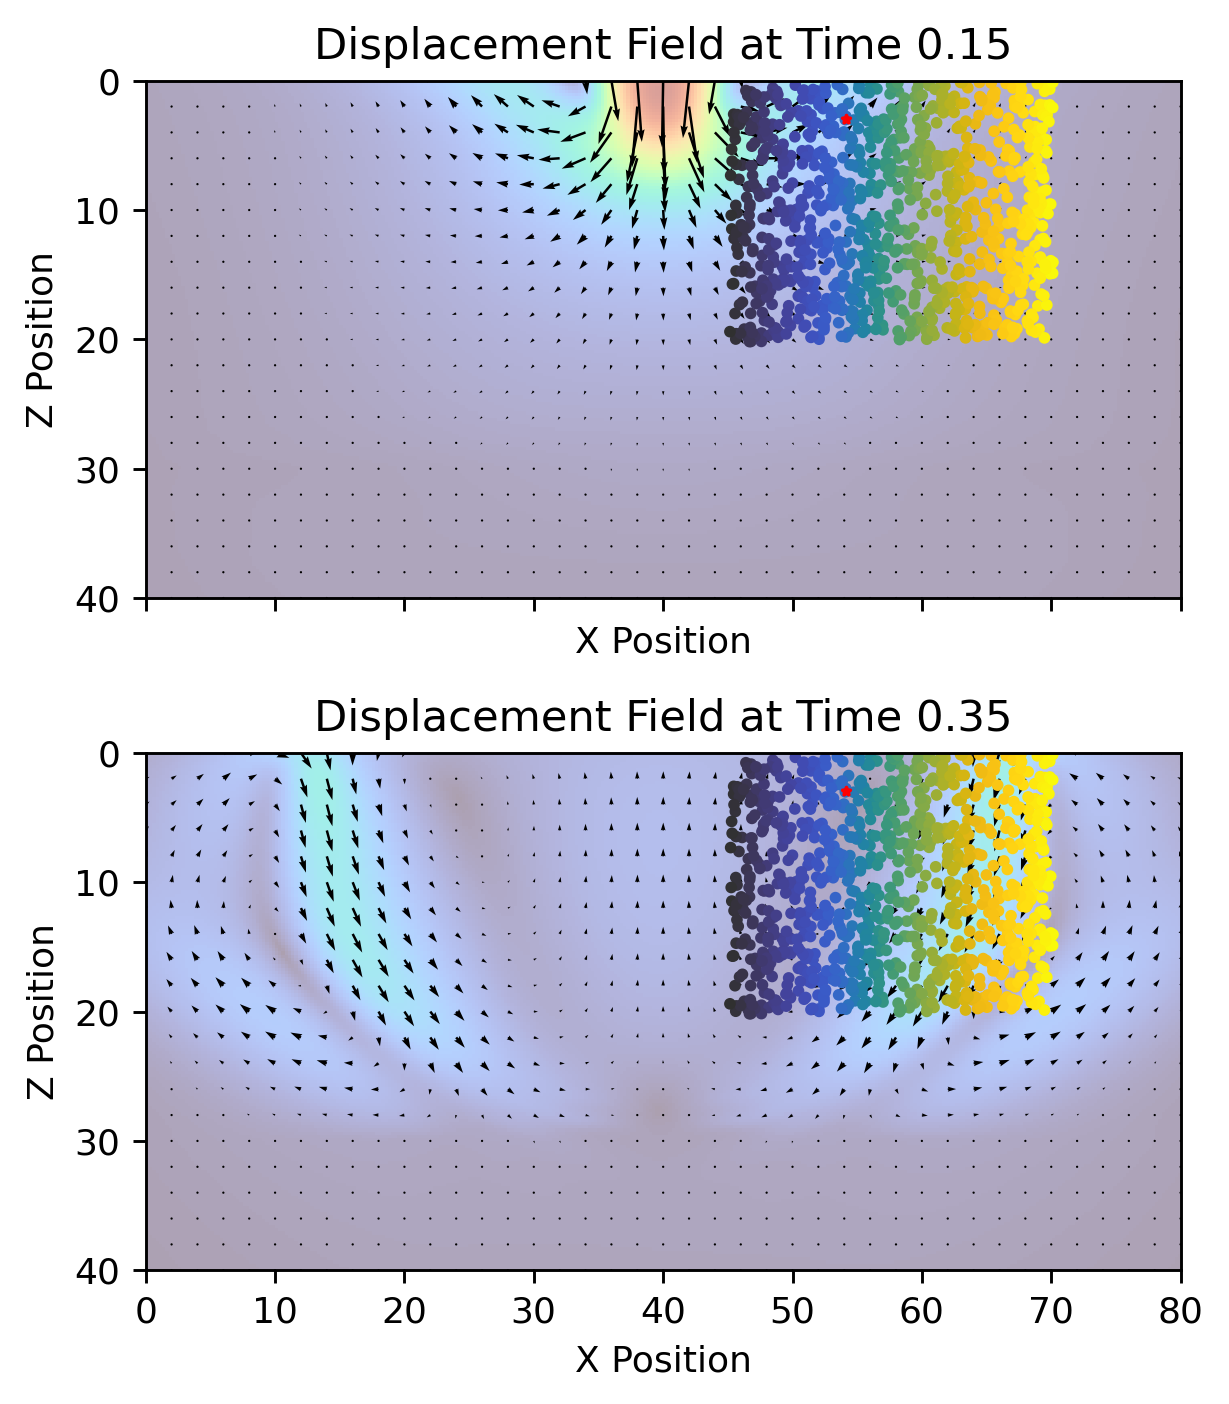

In [7]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

# Initialize the figure for subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 5.5), sharey=True, sharex=True, dpi=260)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index

clip = 1
divnorm = colors.TwoSlopeNorm(vmin=disp_z.min()/clip, vcenter=0, vmax=disp_z.max()/clip)

# Time frames to plot
time_frames = [150, 350]  # Adjust these to the frames you want to plot

for i, frame in enumerate(time_frames):
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Creating the quiver plot for the current frame
    axs[i].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
    im = axs[i].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4)
    #im = axs[i].imshow(disp_z[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='RdBu', norm=divnorm, alpha=0.4)
    
    axs[i].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, s=5)

    axs[i].scatter(scatterers[scat, 0]*dx, scatterers[scat, 1]*dx, c='red', marker='*', s=5)

    #plt.colorbar(im)
    axs[i].set_xlabel('X Position')
    axs[i].set_ylabel('Z Position')
    axs[i].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

plt.tight_layout()

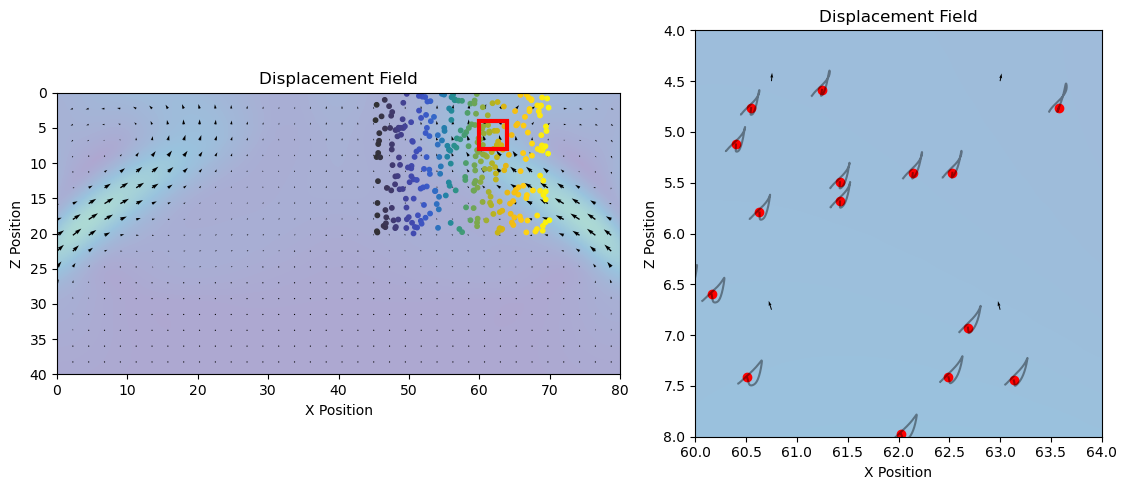

In [133]:
from matplotlib.patches import Rectangle

# Downsampling factor and meshgrid setup
factor = 9
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

window_zoom = [(60, 4), 4, 4]

# Find indices of scatterers within the smaller window
inside_indices = np.where(
    (scatterers[:, 0] >= window_zoom[0][0]/dx) &
    (scatterers[:, 0] <= (window_zoom[0][0]+window_zoom[1])/dx) &
    (scatterers[:, 1] >= window_zoom[0][1]/dx) &
    (scatterers[:, 1] <= (window_zoom[0][1]+window_zoom[2])/dx)
)[0]

# Initialize the figure for the animation
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

def update(frame):
    axs[0].clear()  # Clear the previous plot
    axs[1].clear()

    # Calculate displacement slices for current frame
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Create the quiver plot for the current frame
    axs[0].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=9)
    axs[0].imshow(total_disp[frame, :, :].T, interpolation='gaussian', extent=[0, x_model, y_model, 0], cmap='Spectral_r', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.5, aspect='equal')
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Z Position')
    axs[0].set_title('Displacement Field')
    axs[0].add_patch(Rectangle(*window_zoom, edgecolor='red', facecolor='none', lw=3, zorder=10))
    axs[0].scatter(np.array(list(scatterer_history.values()))[:, frame, 0]*dx, np.array(list(scatterer_history.values()))[:, frame, 1]*dx, c=scatterers[:, 0]*dx, s=10, cmap=cc.cm.gouldian)

    ##### Zoom axis

    axs[1].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=4)
    axs[1].imshow(total_disp[frame, :, :].T, interpolation='gaussian', extent=[0, x_model, y_model, 0], cmap='Spectral_r', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.5, aspect='equal')
    axs[1].set_xlabel('X Position')
    axs[1].set_ylabel('Z Position')
    axs[1].set_title('Displacement Field')
    axs[1].set(xlim=(window_zoom[0][0], window_zoom[0][0]+window_zoom[1]), ylim=(window_zoom[0][1]+window_zoom[2], window_zoom[0][1]))
    axs[1].scatter(np.array(list(scatterer_history.values()))[:, frame, 0]*dx, np.array(list(scatterer_history.values()))[:, frame, 1]*dx, color='red') 

    for i in inside_indices:
        axs[1].plot(np.array(list(scatterer_history.values()))[i, :frame, 0]*dx, np.array(list(scatterer_history.values()))[i, :frame, 1]*dx, c='k', alpha=0.4, zorder=1)

    plt.tight_layout()

# Number of frames for the animation
num_frames = (disp_x.shape[0]//3)*2

# Creating the animation
ani = FuncAnimation(fig, update, frames=range(0, num_frames, 5), interval=105)

# Save the animation
ani.save('displacement_animation_with_dynamic_scatterers.mp4', writer='ffmpeg')

plt.show()

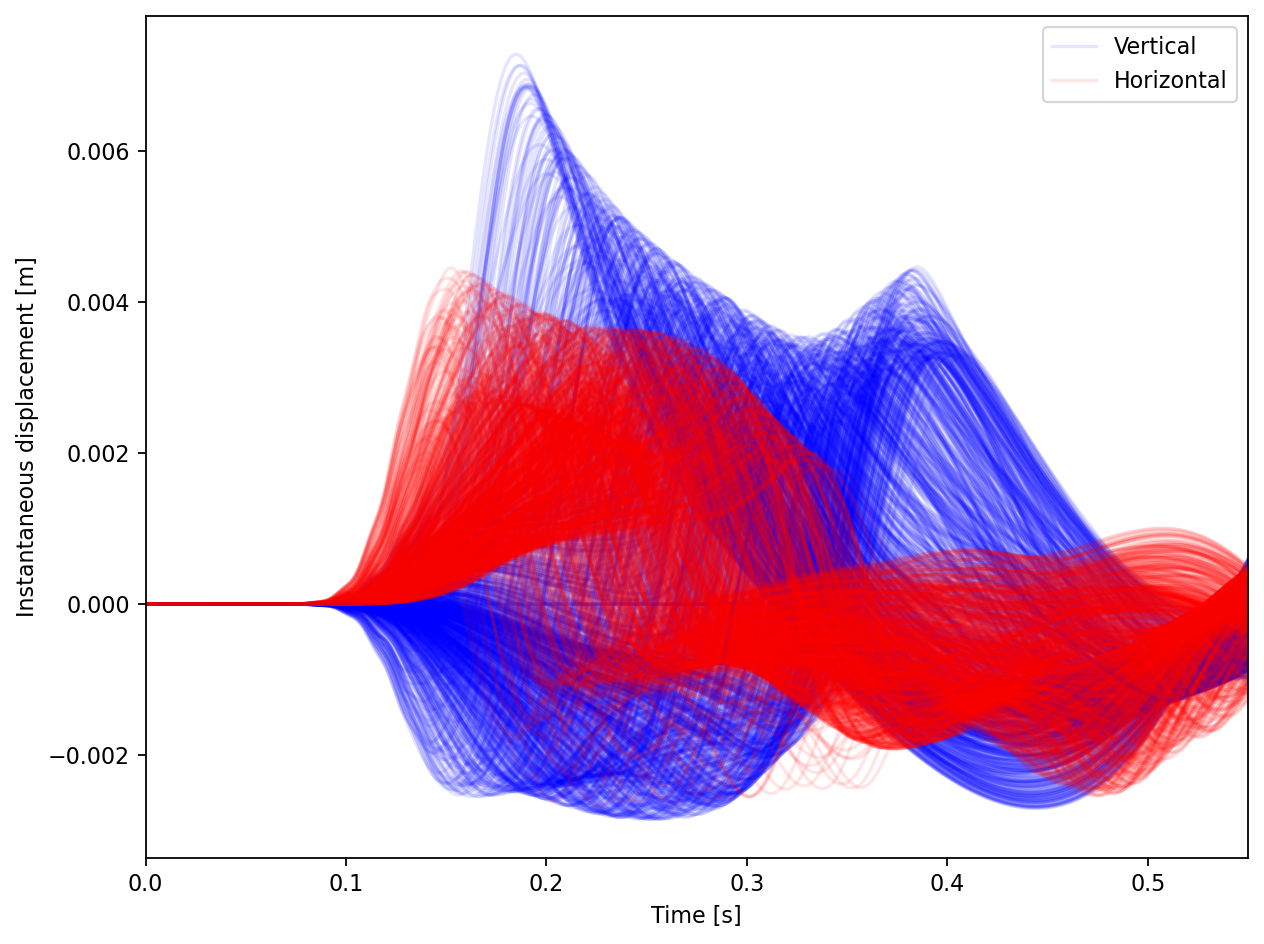

In [8]:
plt.figure(dpi=160, figsize=(8, 6))
time_axs = np.linspace(0, disp_x.shape[0]*dtsnap, disp_x.shape[0])

time_axs_inst = time_axs[1:]  

for i in range(num_scatterers-1):
    plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0), c='b', alpha=0.1)

for i in range(num_scatterers-1):
    plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[i])[:, 0]*dx, axis=0), c='r', alpha=0.1)


plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[num_scatterers-1])[:, 1]*dx, axis=0), c='b', alpha=0.1, label='Vertical')
plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[num_scatterers-1])[:, 0]*dx, axis=0), c='r', alpha=0.1, label='Horizontal')

plt.xlabel('Time [s]')
plt.ylabel('Instantaneous displacement [m]')
plt.tight_layout()
plt.xlim(0, 0.55)
plt.legend()

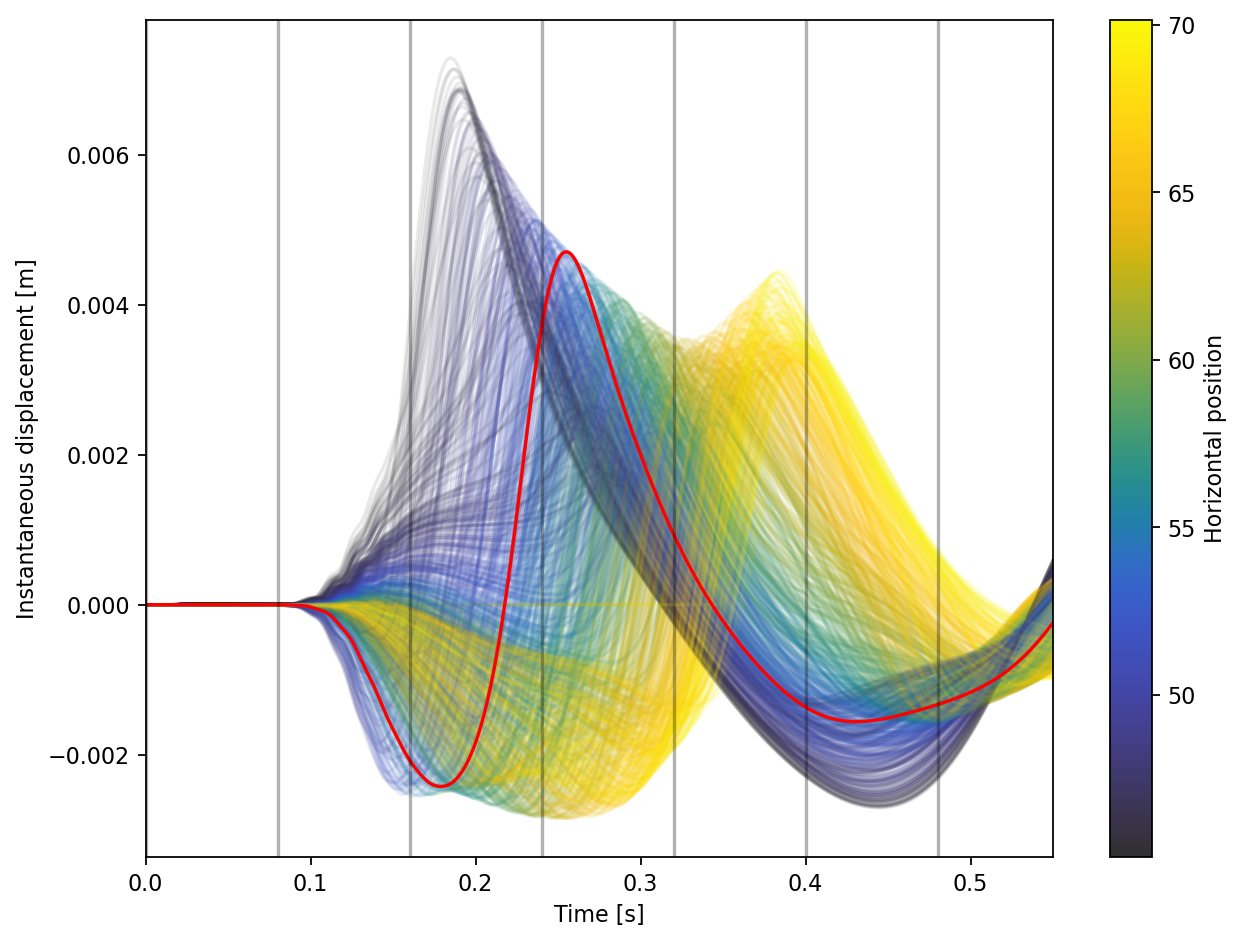

In [9]:
# Plot time vs displacement for each scatterer, color-coded by initial position
fig, ax = plt.subplots(dpi=160, figsize=(8, 6))

time_vector = np.arange(disp_x.shape[0]) * dtsnap
norm = Normalize(vmin=scatterers[:, 0].min()*dx, vmax=scatterers[:, 0].max()*dx)
cmap = plt.get_cmap(cc.cm.gouldian)

for i in range(num_scatterers):
    initial_x_position = scatterers[i, 0]*dx
    color = cmap(norm(initial_x_position))
    im = ax.plot(time_axs_inst, _arr := np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0), color=color, alpha=0.1)

    # max_point = np.argmax(_arr)
    # ax.scatter(time_axs_inst[max_point], _arr[max_point], c='k')

ax.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[scat])[:, 1]*dx, axis=0), color='red', alpha=1)

# Fix for colorbar creation
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Horizontal position')

# # Add vertical lines at specified time intervals
for t in np.arange(0, 0.55, 0.08):
    plt.axvline(t, color='black', alpha=0.3)

ax.set_xlim(0,0.55)
ax.set_xlabel('Time [s]')
plt.tight_layout()
ax.set_ylabel('Instantaneous displacement [m]')
plt.show()


In [19]:
# Assuming the relevant variables are: disp_x, dtsnap, scatterers, num_scatterers, scatterer_history, time_axs_inst, and any other used but not mentioned in the snippet
variables_to_save = {
    'disp_x': disp_x,
    'dtsnap': dtsnap,
    'scatterers': scatterers,
    'num_scatterers': num_scatterers,
    'scatterer_history': scatterer_history,
    'time_axs_inst': time_axs_inst,
}

# Save the variables into a pickle file
with open('/home/riascodc/Documents/ARF/Images/img_npy/velocity.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)


The average frequency is: 3.04125 Hz


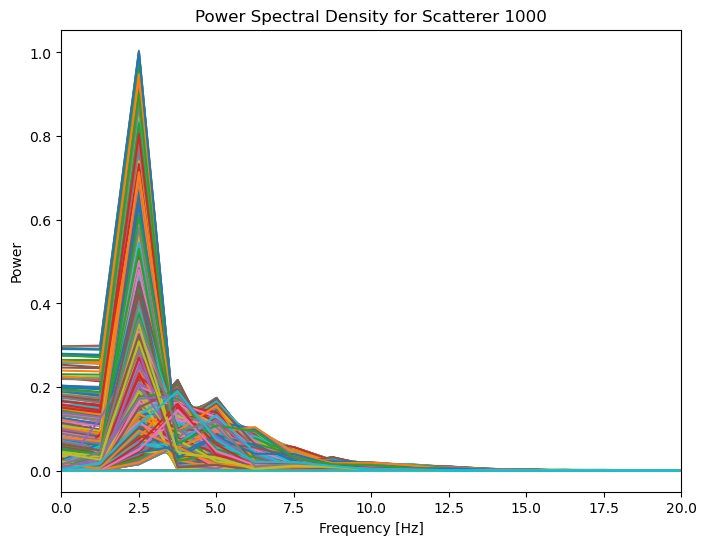

In [14]:
import numpy as np
from scipy.fft import fft
from matplotlib.colors import Normalize
import colorcet as cc
import matplotlib.pyplot as plt

def perform_fft_analysis(scatterer_history, dtsnap, dx):
    # Number of scatterers
    num_scatterers = len(scatterer_history)
    
    # Create a time vector based on the size of the first scatterer's history
    time_vector = np.arange(len(next(iter(scatterer_history.values())))) * dtsnap
    
    # Sampling frequency
    Fs = 1 / dtsnap
    
    # Prepare a list to hold frequencies for each scatterer
    frequencies_list = []

    plt.figure(figsize=(8, 6))
    
    for i, history in enumerate(scatterer_history.values()):
        # Get the instantaneous displacement and compute its difference
        displacement = np.diff(np.array(history)[:, 1] * dx, axis=0)
        
        # Compute the FFT
        yf = fft(displacement)
        
        # Compute the power spectrum density (PSD)
        psd = np.abs(yf) ** 2
        
        # Create a frequency vector
        freq_vector = np.fft.fftfreq(displacement.size, d=dtsnap)
        
        # Find the dominant frequency, which is the frequency with the highest power
        # Ignoring the zero frequency (mean of the signal)
        idx = np.argmax(psd[1:]) + 1  # +1 to correct the index for skipping the zero frequency
        dominant_frequency = abs(freq_vector[idx])
        
        # Save the dominant frequency for this scatterer
        frequencies_list.append(dominant_frequency)
        
        # Plotting the PSD
        plt.plot(freq_vector, psd)
        plt.title(f"Power Spectral Density for Scatterer {i+1}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power")
        plt.xlim(0, 20)  # Show only the positive frequencies
    
    # Calculate the average frequency
    average_frequency = np.mean(frequencies_list)
    print(f"The average frequency is: {average_frequency} Hz")
    
    return frequencies_list

# Call the function using the provided variables
fft_frequencies = perform_fft_analysis(scatterer_history, dtsnap, dx)


In [10]:
x_pos = []
t_max = []

for i in range(num_scatterers):
    x_pos.append(scatterers[i, 0]*dx)
    t_max.append(np.argmax(np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0))*dtsnap)

# for i in range(num_scatterers):
#     positions = []
#     times = []
#     x_pos.append(scatterers[i, 0]*dx)

#     for ix in np.arange(80, 801-190, 80):
#         positions.append((np.array(scatterer_history[i])[ix, 1] - np.array(scatterer_history[i])[ix-80, 1])*dx)
#         times.append(ix)
    
#     t_max.append(times[np.argmax(np.array(positions))]*dtsnap)

Text(0, 0.5, 'Travel distance [m]')

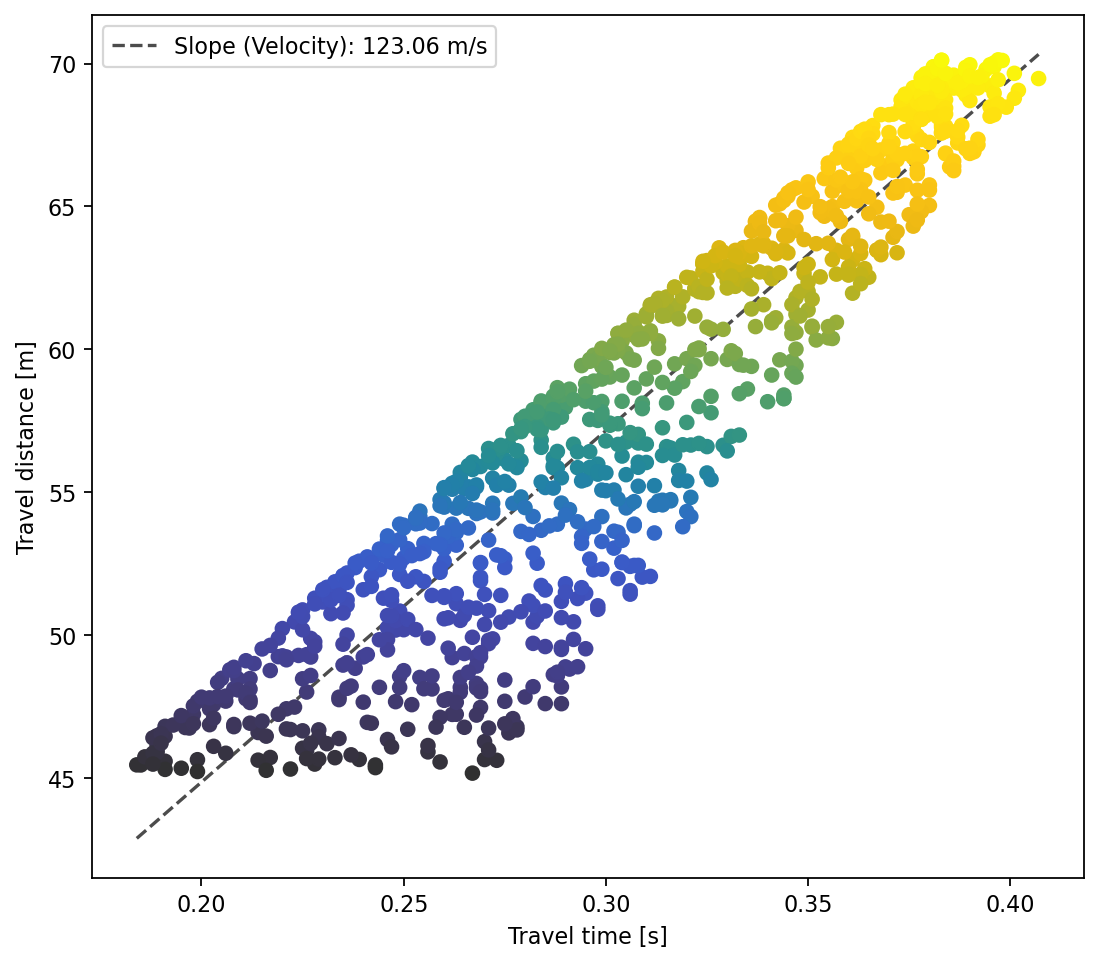

In [11]:
plt.figure(dpi=160, figsize=(8, 7))

plt.scatter(t_max, x_pos, c=x_pos, cmap=cc.cm.gouldian)

# Perform linear regression to fit a line
slope, intercept = np.polyfit(t_max, x_pos, 1)

# Now use the slope and intercept to create the line
timeaxis = np.linspace(min(t_max), max(t_max), 100)
disaxis = slope * timeaxis + intercept

plt.plot(timeaxis, disaxis, '--', alpha=0.7, c='k', zorder=0, label=f'Slope (Velocity): {slope:.2f} m/s')
plt.legend()

plt.xlabel('Travel time [s]')
plt.ylabel('Travel distance [m]')

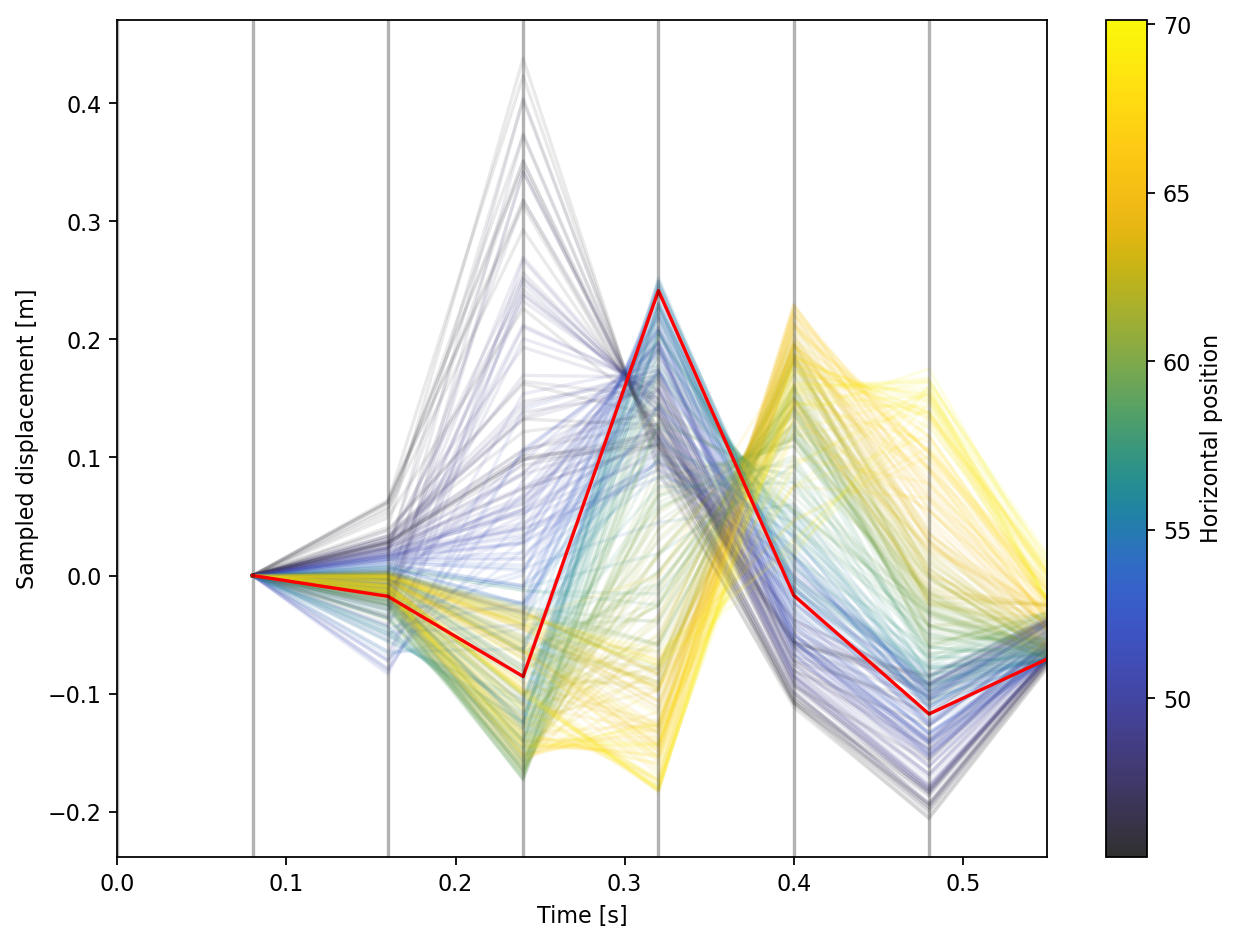

In [12]:
# Plot time vs displacement for each scatterer, color-coded by initial position
fig, ax = plt.subplots(dpi=160, figsize=(8, 6))

time_vector = np.arange(disp_x.shape[0]) * dtsnap
norm = Normalize(vmin=scatterers[:, 0].min()*dx, vmax=scatterers[:, 0].max()*dx)
cmap = plt.get_cmap(cc.cm.gouldian)

for i in range(num_scatterers):
    initial_x_position = scatterers[i, 0]*dx
    color = cmap(norm(initial_x_position))

    positions = []
    times = []

    for ix in np.arange(80, 801-80, 80):
        positions.append((np.array(scatterer_history[i])[ix, 1] - np.array(scatterer_history[i])[ix-80, 1])*dx)
        times.append(ix)

    ax.plot(np.array(times)*dtsnap, positions, color=color, alpha=0.1)

positions = []
times = []

for ix in np.arange(80, 801-80, 80):
    positions.append((np.array(scatterer_history[scat])[ix, 1] - np.array(scatterer_history[scat])[ix-80, 1])*dx)
    times.append(ix)

ax.plot(np.array(times)*dtsnap, positions, color='red', alpha=1)

# Fix for colorbar creation
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Horizontal position')

# # Add vertical lines at specified time intervals
for t in np.arange(0, 0.55, 0.08):
    plt.axvline(t, color='black', alpha=0.3)

ax.set_xlim(0,0.55)
ax.set_xlabel('Time [s]')
plt.tight_layout()
ax.set_ylabel('Sampled displacement [m]')
plt.show()


# Simulation of experiment

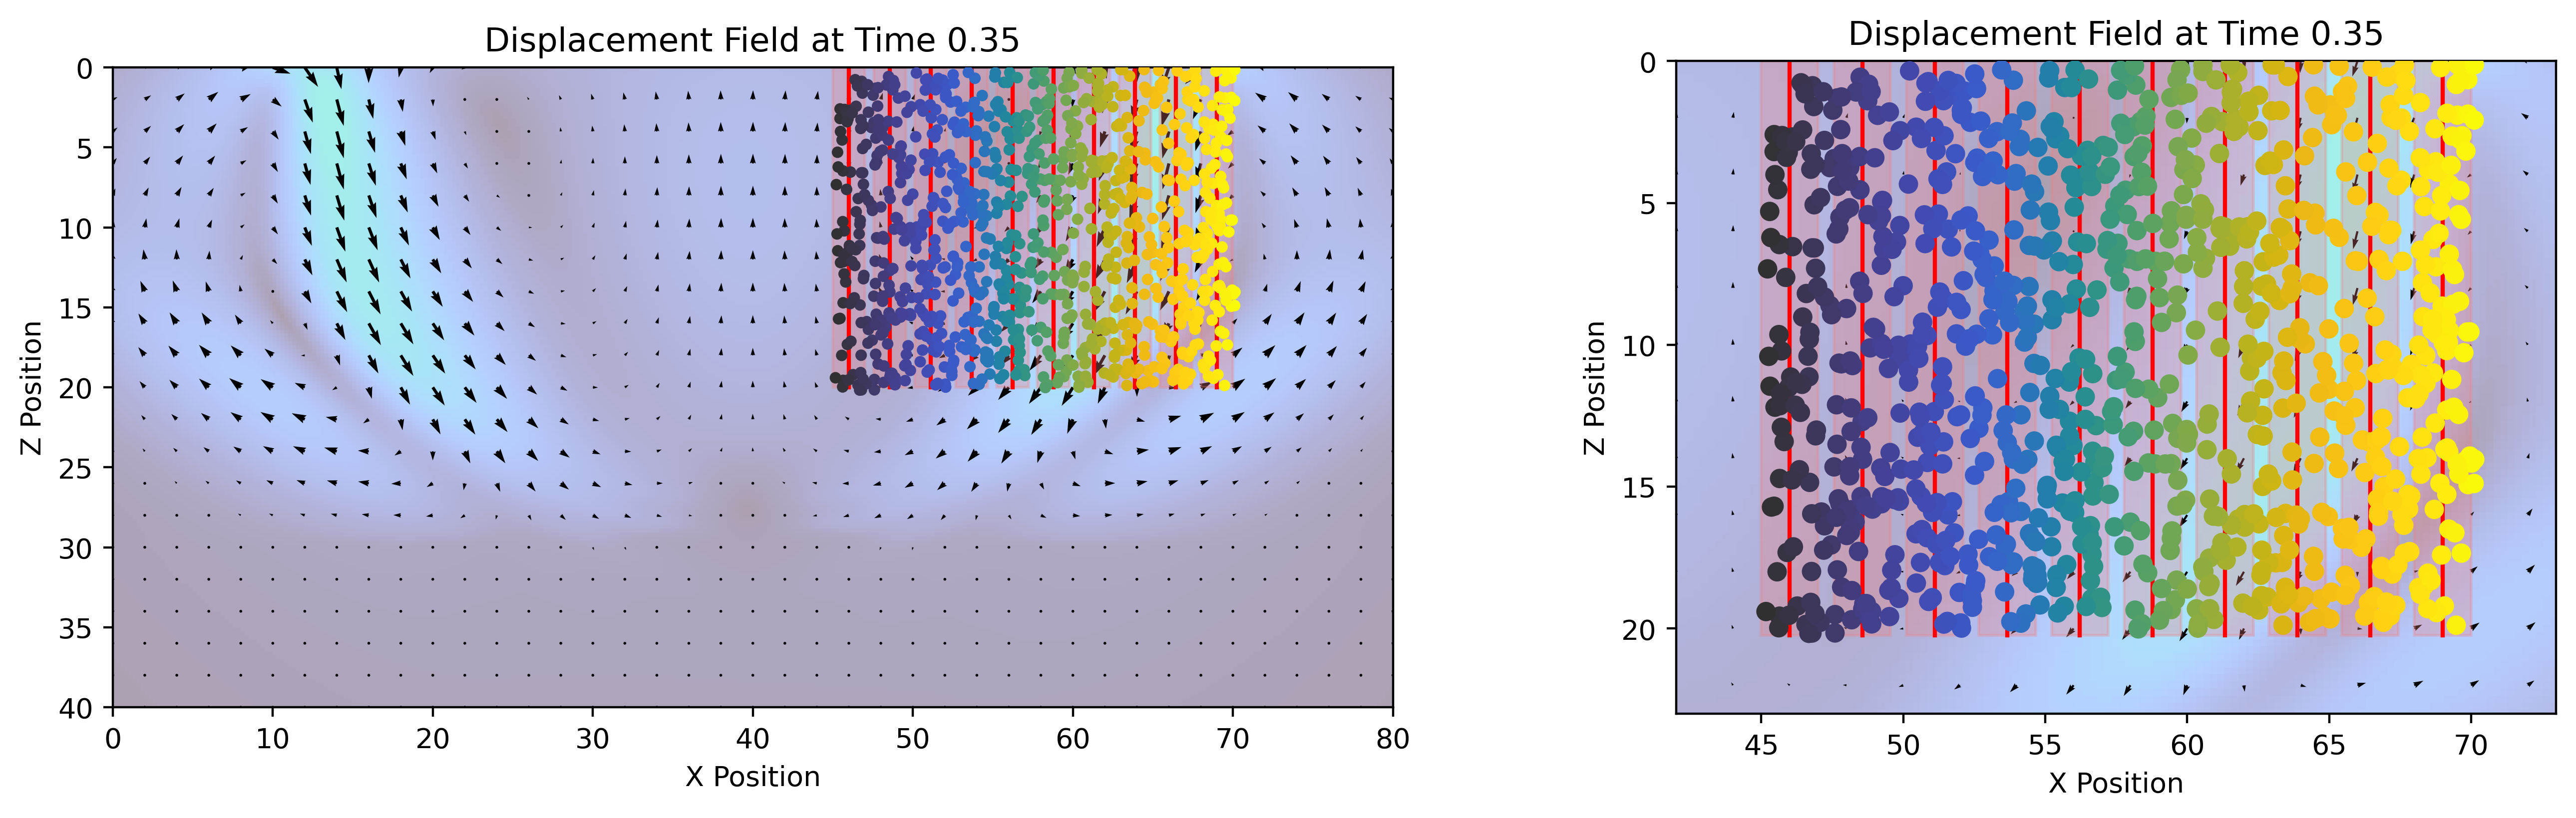

In [7]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]
frame=350

# Sensors location 
num_receivers = 10
beamwidth = 2
receiver_positions = np.linspace(window[0]*dx + beamwidth/2, window[1]*dx - beamwidth/2, num_receivers)

# Initialize the figure for subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 4.2), dpi=400)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index

disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
disp_x_downsampled = disp_x_slice[::factor, ::factor]
disp_z_downsampled = disp_z_slice[::factor, ::factor]

# Creating the quiver plot for the current frame
axs[0].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
im = axs[0].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4, aspect='equal')
axs[0].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, s=10, zorder=15)

# Creating the quiver plot for the current frame
axs[1].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
im = axs[1].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4, aspect='equal')
axs[1].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, zorder=15)

for pos in receiver_positions:
    axs[0].axvline(pos, ymin=0.5, ymax=1, color='red')
    axs[0].axvspan(pos-1, pos+1, ymin=0.5, ymax=1, color='lightcoral', alpha=0.3)

for pos in receiver_positions:
    axs[1].axvline(pos, ymin=0.12, ymax=1, color='red')
    axs[1].axvspan(pos-1, pos+1, ymin=0.12, ymax=1, color='lightcoral', alpha=0.3)

axs[1].set_xlabel('X Position')
axs[1].set_ylabel('Z Position')
axs[1].set(xlim=(window[0]*dx-3, window[1]*dx+3), ylim=(window[2]*dx+3, 0))
axs[1].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Z Position')
axs[0].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

plt.tight_layout()

In [16]:
# List of variable names you want to save
variables_to_save = ['x_model', 'y_model', 'dx', 'dtsnap', 'factor', 'disp_x', 'disp_z', 'total_disp', 'scatterers', 'window', 'num_receivers', 'beamwidth', 'receiver_positions']

# Dictionary to hold your variables
data_to_save = {}

for var in variables_to_save:
    data_to_save[var] = globals()[var]

# Save the dictionary into a pickle file
with open('/home/riascodc/Documents/ARF/Images/img_npy/scatterers.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [8]:
central_frequency = 12000  # Hz
sampling_rate = 20000  # Hz
duration = 0.09  # Seconds
points = int(duration * sampling_rate)
speed_of_sound = 1500  # m/s
np.random.seed(0)

# Assuming other parameters (central_frequency, sampling_rate, etc.) are defined as before
num_time_steps = len(scatterer_history[0])  # Assuming this is defined as before

# Generate Ricker wavelet
wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)

def simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes):
    signals_time_steps = np.zeros((num_receivers, num_time_steps, points))

    for frame in range(num_time_steps):
        for i, pos in enumerate(receiver_positions):
            signals_frame = np.zeros(points)
            
            # Retrieve scatterers' positions for this frame
            scatterers_frame = np.array([scatterer_history[sc][frame] for sc in range(num_scatterers)])
            
            # Filter scatterers within the beamwidth of the current receiver and use fixed amplitudes
            for scatterer_index, scatterer in enumerate(scatterers_frame):
                if pos - beamwidth/2 <= scatterer[0]*dx <= pos + beamwidth/2:
                    depth = scatterer[1] * dx
                    spike_time = int(((2 * (depth+40)) / speed_of_sound) * sampling_rate)
                    if spike_time < points:
                        signals_frame[spike_time] += scatterer_amplitudes[scatterer_index]  # Use fixed amplitude

            # Convolve signal with Ricker wavelet
            signals_time_steps[i, frame, :] = convolve(signals_frame, wavelet, mode='same')

    return signals_time_steps

# Simulate and plot signals with fixed amplitudes
sigs = simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes)

/tmp/ipykernel_1959140/1156113470.py:12: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)


In [14]:
signals_time_steps_one = np.zeros((num_time_steps, points))
depths = []

for frame in range(num_time_steps):
    signals_frame = np.zeros(points)

    depth = scatterer_history[scat][frame][1] * dx
    depths.append(depth)
    spike_time = int(((2 * (depth+40)) / speed_of_sound) * sampling_rate)
    if spike_time < points:
        signals_frame[spike_time] += scatterer_amplitudes[scat]  # Use fixed amplitude

    # Convolve signal with Ricker wavelet
    signals_time_steps_one[frame, :] = convolve(signals_frame, wavelet, mode='same')

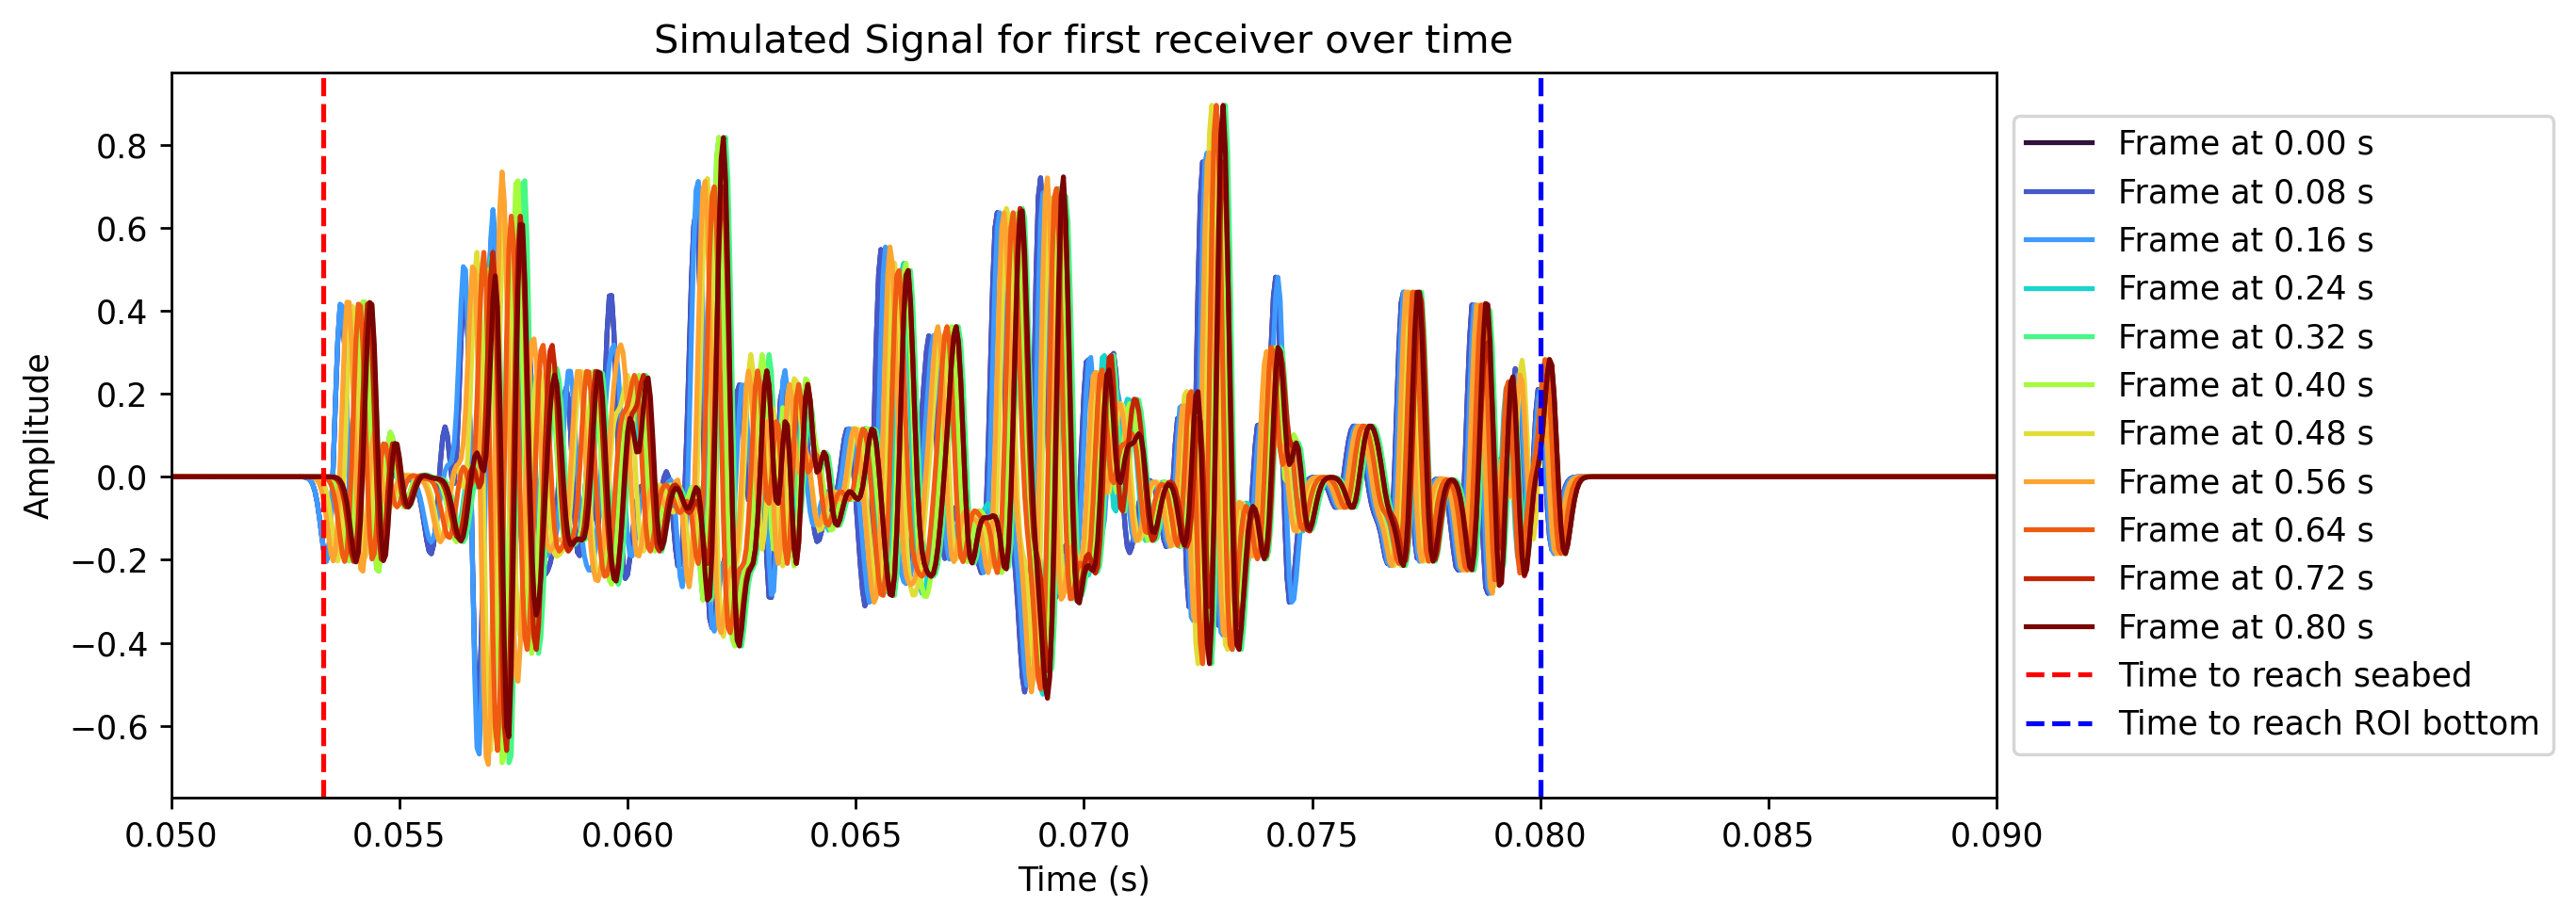

In [9]:
from matplotlib import cm

# Plotting the signals for the first receiver as an example
fig, ax = plt.subplots(figsize=(10, 4), dpi=250)
time = np.arange(points) / sampling_rate
colors = cm.turbo(np.linspace(0, 1, num_time_steps))

for frame in range(0, num_time_steps, 80):
    ax.plot(time, sigs[0, frame, :], color=colors[frame], label=f'Frame at {frame*dtsnap:.2f} s' if frame % (num_time_steps // 80) == 0 else "")
    #ax.plot(time, signals_time_steps_one[frame, :], color=colors[frame], label=f'Frame at {frame*dtsnap:.2f} s' if frame % (num_time_steps // 80) == 0 else "")

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Simulated Signal for first receiver over time')
plt.xlim(0.05, duration)
plt.axvline(80/speed_of_sound, label='Time to reach seabed', color='red', ls='--')
plt.axvline(120/speed_of_sound, label='Time to reach ROI bottom', color='blue', ls='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
# Bundle your variables into a dictionary
data_to_save = {
    "points": points,
    "sampling_rate": sampling_rate,
    "num_time_steps": num_time_steps,
    "dtsnap": dtsnap,
    "duration": duration,
    "speed_of_sound": speed_of_sound,
    "sigs": sigs,
}

# Save the dictionary into a pickle file
with open("/home/riascodc/Documents/ARF/Images/img_npy/signals.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

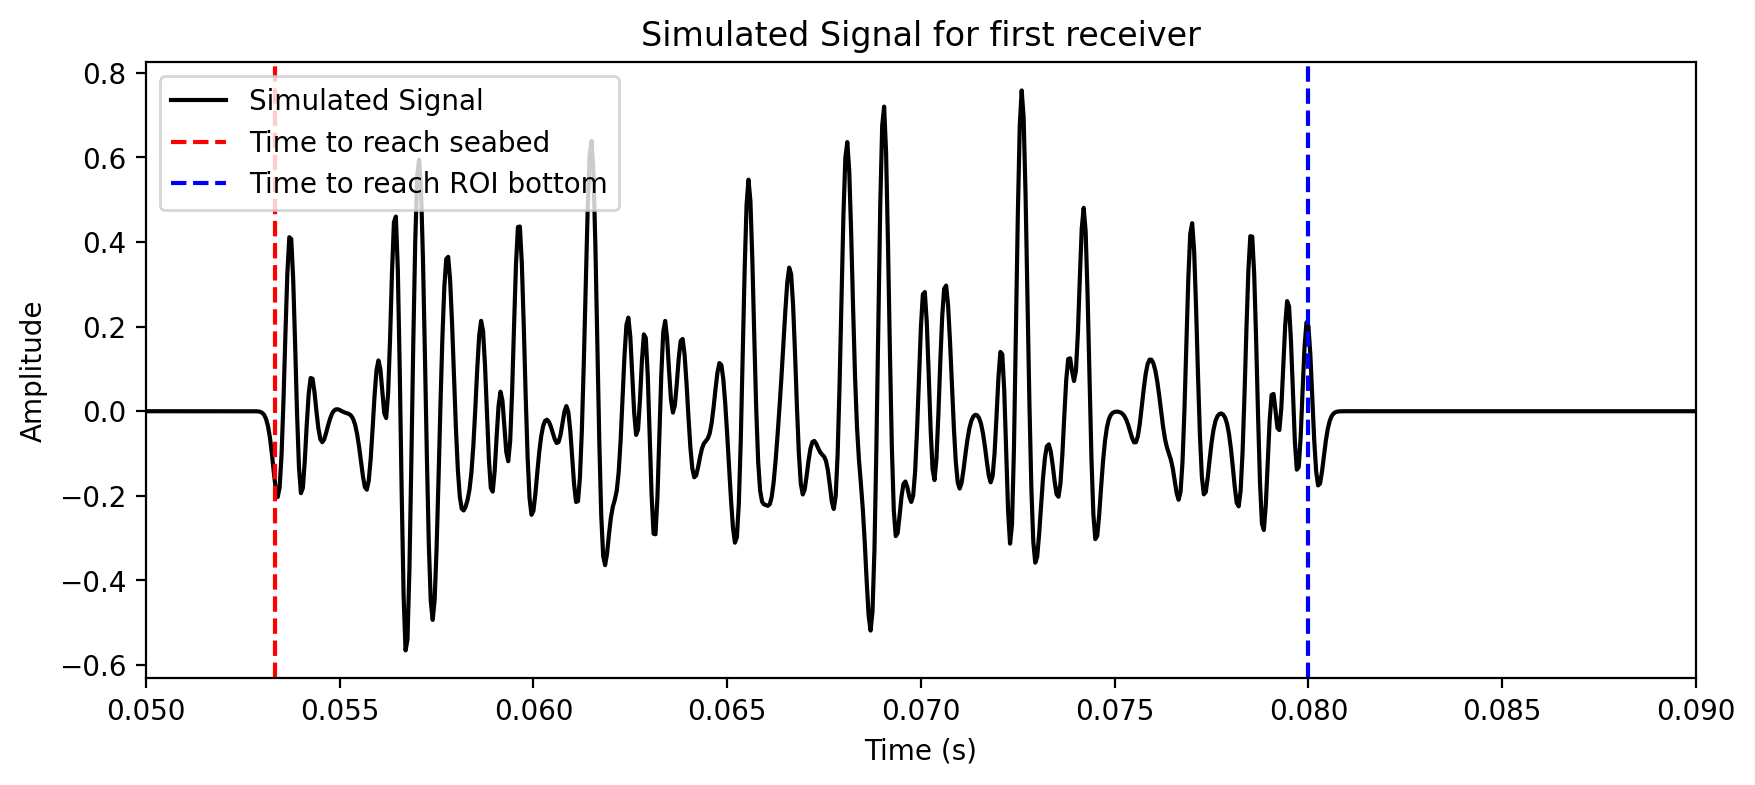

In [10]:
plt.figure(figsize=(10, 4), dpi=200)
plt.plot(np.arange(points) / sampling_rate, sigs[0, 0, :], label='Simulated Signal', color='k')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Simulated Signal for first receiver')
plt.xlim(0.05, duration)
plt.axvline(80/speed_of_sound, label='Time to reach seabed', color='red', ls='--')
plt.axvline(120/speed_of_sound, label='Time to reach ROI bottom', color='blue', ls='--')
plt.legend(loc=2)
plt.show()

In [13]:
def find_displacement(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound):
    # Extract the two signals for correlation
    signal1 = sigs[receiver_index, time_step1, :]
    signal2 = sigs[receiver_index, time_step2, :]
    
    # Perform 1D correlation
    correlation = correlate(signal1, signal2, mode='full')
    
    # Find the index of the maximum correlation
    shift_index = np.argmax(correlation) - len(signal1) + 1
    
    # Calculate dt, the time shift in seconds
    dt = shift_index / sampling_rate
    
    # Calculate dz, the displacement in meters
    dz = speed_of_sound * dt / 2  # Division by 2 due to round trip

    num_points = 3  # number of points on each side of the peak
    peak_index = np.argmax(correlation)
    fit_indices = np.arange(peak_index - num_points, peak_index + num_points + 1)
    fit_times = (fit_indices - len(signal1) + 1) / sampling_rate
    fit_values = correlation[fit_indices]

    # Fit a parabola to these points
    fit_coeffs = Polynomial.fit(fit_times, fit_values, 2).convert().coef

    # Find the vertex of the parabola (time shift with higher accuracy)
    vertex_t = -fit_coeffs[1] / (2 * fit_coeffs[2])

    # Recalculate dz using the refined time shift
    refined_dt = vertex_t
    refined_dz = speed_of_sound * refined_dt / 2  # Division by 2 due to round trip
    
    return refined_dz, refined_dt, shift_index, correlation

# Example usage
receiver_index = 2  # For the first receiver
time_step1 = 240  # Initial time step
time_step2 = 360  # A later time step

dz, dt, shift_index, correlation = find_displacement(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound)

print(f"Displacement: {dz} meters, Time Shift: {dt} seconds, Shift Index: {shift_index}")

Displacement: -0.18126392545046874 meters, Time Shift: -0.00024168523393395833 seconds, Shift Index: -5


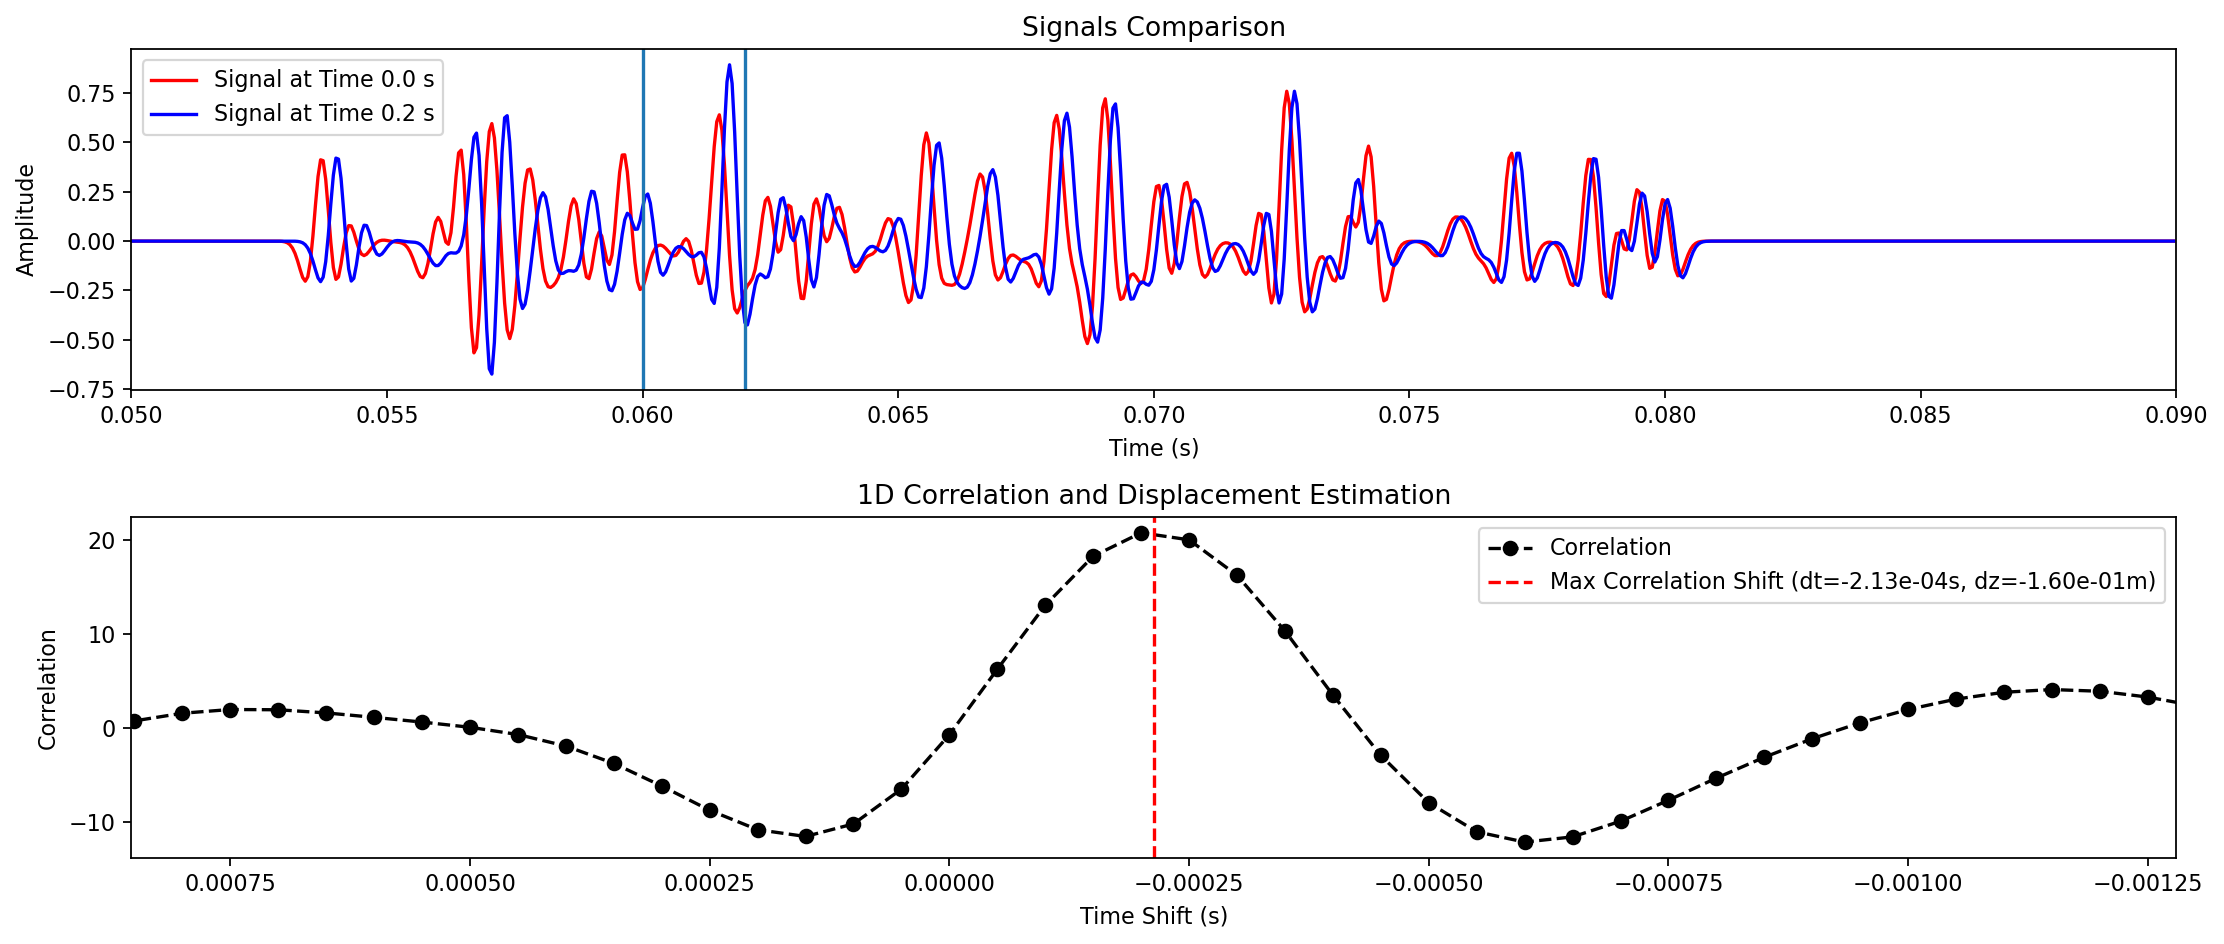

Estimated Displacement: -0.16 meters, Time Shift: -2.13e-04 seconds


In [14]:
# Reusing the find_displacement function from before, now with visualization added
def visualize_displacement_and_correlation(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound):
    dz, dt, shift_index, correlation = find_displacement(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound)
    
    # Time vectors for plotting
    t_signal = np.arange(sigs.shape[2]) / sampling_rate
    t_correlation = np.arange(-len(t_signal) + 1, len(t_signal)) / sampling_rate
    
    # Plotting the signals
    plt.figure(figsize=(14, 6), dpi=160)
    plt.subplot(2, 1, 1)
    plt.plot(t_signal, sigs[receiver_index, time_step1, :], label=f'Signal at Time {time_step1*dtsnap} s', c='red')
    plt.plot(t_signal, sigs[receiver_index, time_step2, :], label=f'Signal at Time {time_step2*dtsnap} s', c='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Signals Comparison')
    plt.legend(loc=2)
    plt.xlim(0.05, 0.09)

    plt.axvline(0.060)
    plt.axvline(0.060 + 0.002)
    
    # Plotting the correlation
    plt.subplot(2, 1, 2)
    plt.plot(t_correlation, correlation, label='Correlation', c='k', ls='--', marker='o')
    plt.axvline(x=dt, color='r', linestyle='--', label=f'Max Correlation Shift (dt={dt:.2e}s, dz={dz:.2e}m)')
    plt.xlabel('Time Shift (s)')
    plt.ylabel('Correlation')
    plt.title('1D Correlation and Displacement Estimation')
    plt.legend()
    plt.xlim(dt-5*dt, dt+5*dt)
    plt.tight_layout()
    plt.show()

    return dz, dt

# Example usage
dz, dt = visualize_displacement_and_correlation(sigs, receiver_index=0, time_step1=0, time_step2=200, sampling_rate=sampling_rate, speed_of_sound=speed_of_sound)
print(f"Estimated Displacement: {dz:.2f} meters, Time Shift: {dt:.2e} seconds")


In [20]:
signal1 = sigs[0, 100, :]
signal2 = sigs[0, 200, :]

wl = 0.003  # seconds

def windowed_cross_correlation(signal1, signal2, window_length, sampling_rate = sampling_rate, speed_of_sound = speed_of_sound):

    srl = wl * 2  # seconds

    window_samples = int(wl * sampling_rate)
    search_region_samples = int(srl * sampling_rate)

    displacements = []
    times = []

    for i in range(window_samples // 2, len(signal2) - window_samples // 2, window_samples // 4):
        times.append(i)

        window = signal2[i - window_samples // 2: i + window_samples // 2]
        search_region = signal1[max(i - search_region_samples // 2, 0): i + search_region_samples // 2]

        if np.all(window == 0) or np.all(search_region == 0):
            displacements.append(0)
        
        else:
            correlation = correlate(search_region, window, mode='full')

            if correlation.max() > 1e-1:
                sorted_idx = np.argsort(correlation)
                top3 = sorted_idx[-5:]

                if np.abs(top3[-1] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-1]
                
                elif np.abs(top3[-2] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-2]

                else:
                    displacements.append(np.nan)
                    continue

                num_points = 3  # Points on each side of the peak for fitting
                fit_indices = np.arange(max(0, peak_index - num_points), min(peak_index + num_points + 1, len(correlation)))
                fit_values = correlation[fit_indices]

                fit_coeffs = np.polyfit(fit_indices, fit_values, 2)
                vertex_index = -fit_coeffs[1] / (2 * fit_coeffs[0])

                shift_samples = vertex_index - ((len(search_region) + len(window)) // 2 - 1)
                refined_dt = shift_samples / sampling_rate
                displacement = (shift_samples / sampling_rate) * speed_of_sound / 2

                displacements.append(displacement)

                if np.abs(shift_samples) > 30:

                    print(top3, np.argmax(correlation))

                    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

                    axs[0].plot(np.linspace(i - window_samples // 2, i + window_samples // 2, len(window)), window, label='Window')
                    axs[0].plot(np.linspace(i - search_region_samples // 2, i + search_region_samples // 2, len(search_region)), search_region, label='Search Region')
                    axs[0].legend()

                    axs[1].plot(correlation, 'k--', marker='o', label='Correlation')
                    axs[1].axvline(peak_index, color='blue', label='Peak Index')
                    axs[1].set_xlim(peak_index - 10*num_points, peak_index + 10*num_points)
                    axs[1].scatter(fit_indices, fit_values, color='red', zorder=5, label='Fit Points')

                    # Plotting the fitted parabola
                    dense_fit_indices = np.linspace(fit_indices[0], fit_indices[-1], num=100)
                    parabola_values = np.polyval(fit_coeffs, dense_fit_indices)
                    axs[1].plot(dense_fit_indices, parabola_values, 'g-', label='Fitted Parabola')
                    axs[1].legend()

                    axs[2].plot(np.linspace(i - window_samples//2, i+window_samples//2, len(window))+shift_samples, window)
                    axs[2].plot(np.linspace(i - search_region_samples//2, i+search_region_samples//2, len(search_region)), search_region)

                    plt.show()

            else:
                displacements.append(np.nan)

    # Convert the list to a NumPy array if it isn't one already
    displacements_array = np.array(displacements)
    non_nan_indices = np.where(~np.isnan(displacements_array))[0]
    nan_indices = np.where(np.isnan(displacements_array))[0]
    displacements_array[nan_indices] = np.interp(nan_indices, non_nan_indices, displacements_array[non_nan_indices])

    return times, displacements_array

times, displacements_array = windowed_cross_correlation(signal1, signal2, wl)

(40.0, 60.0)

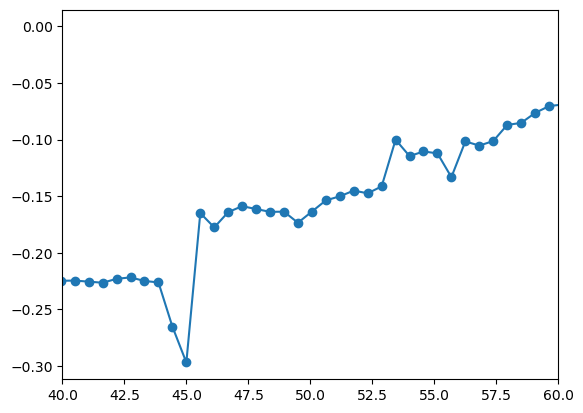

In [12]:
plt.plot((np.array(times)/sampling_rate)*(speed_of_sound/2), displacements_array, marker='o')
plt.xlim(40, 60)

In [21]:
def estimate_displacements_for_all_receivers(sigs, interval, wl = 0.003, dt = dtsnap):
    """
    Estimates displacements for all receivers and returns a matrix with dimensions [time, x, y].
    :param sigs: Signal array with dimensions [receiver, time, sample].
    :param time_step1: The first time step to compare.
    :param time_step2: The second time step to compare.
    :return: 3D matrix of displacements with dimensions [time, x, y].
    """
    num_receivers = sigs.shape[0]

    matrix_time = []
    times = np.arange(0, 500, interval)

    for t in times:
    
        displacements_list = []

        for receiver_index in range(num_receivers):
            signal1 = sigs[receiver_index, t, :]
            signal2 = sigs[receiver_index, t + interval, :]
            _t, displacements = windowed_cross_correlation(signal1, signal2,wl)
            displacements_list.append(displacements) 

        matrix_time.append(np.vstack(displacements_list))

    return times*dt, np.array(matrix_time)


In [24]:
timess, matrix_time = estimate_displacements_for_all_receivers(sigs, 80, wl)
matrix_time = matrix_time[:, :, 69: 105]

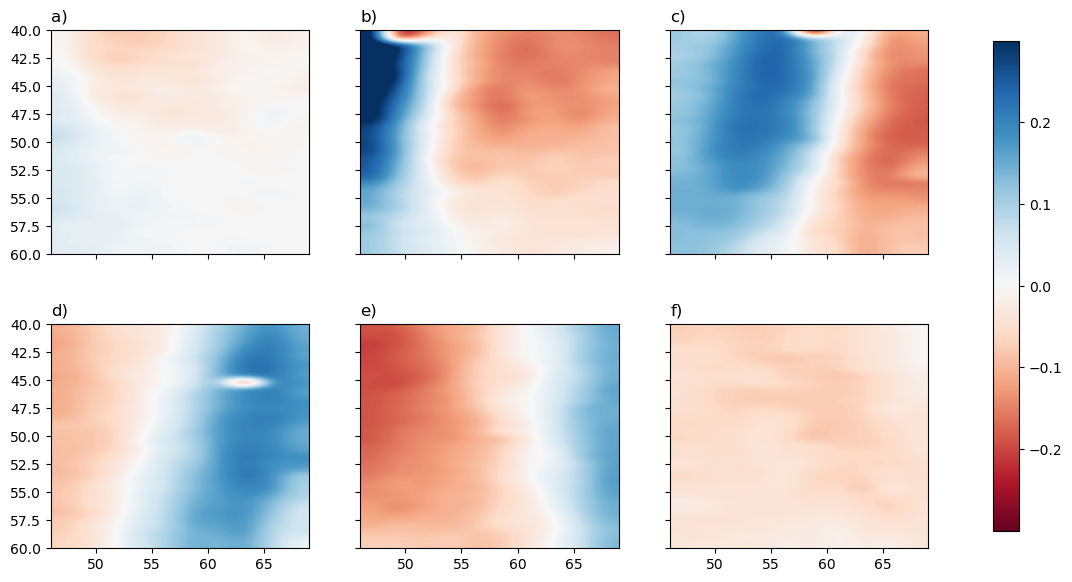

In [16]:
from matplotlib import colors

# Initialize the figure for subplots
clip = 1
divnorm = colors.TwoSlopeNorm(vmin=-0.3/clip, vcenter=0, vmax=0.3/clip)

fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharey=True, sharex=True)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index
titles = ['a', 'b', 'c', 'd', 'e', 'f']

for t, tit in zip(range(1, matrix_time.shape[0], 1), titles):
    im = axs[t-1].imshow(-matrix_time[t].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='bicubic', cmap='RdBu', aspect='equal')
    #axs[t-1].set_ylim(60, 40)
    axs[t-1].set_title(f'{tit})', loc='left')

# Create a colorbar with specific location and size
fig.subplots_adjust(right=0.8)  # Make room for the colorbar on the right
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # Adjust these values as needed
fig.colorbar(im, cax=cbar_ax)


plt.show()

In [84]:
# Bundle your variables into a dictionary
data_to_save = {
    "clip": clip,
    "matrix_time": matrix_time,
    "receiver_positions": receiver_positions,
}

# Save the dictionary into a pickle file
with open("/home/riascodc/Documents/ARF/Images/img_npy/est-disp.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

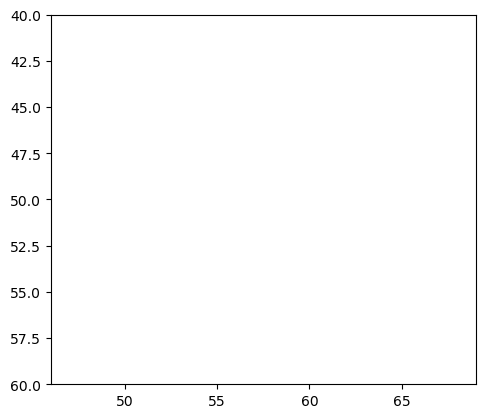

In [117]:
from matplotlib import colors

clip = 1
divnorm = colors.TwoSlopeNorm(vmin=-0.2/clip, vcenter=0, vmax=0.2/clip)

fig = plt.figure()
camera = Camera(fig)

for t in range(matrix_time.shape[0]):
    plt.imshow(matrix_time[t].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='bicubic', cmap='RdBu_r', aspect='equal')
    camera.snap()

animation = camera.animate(interval = 200)
animation.save('video.mp4')

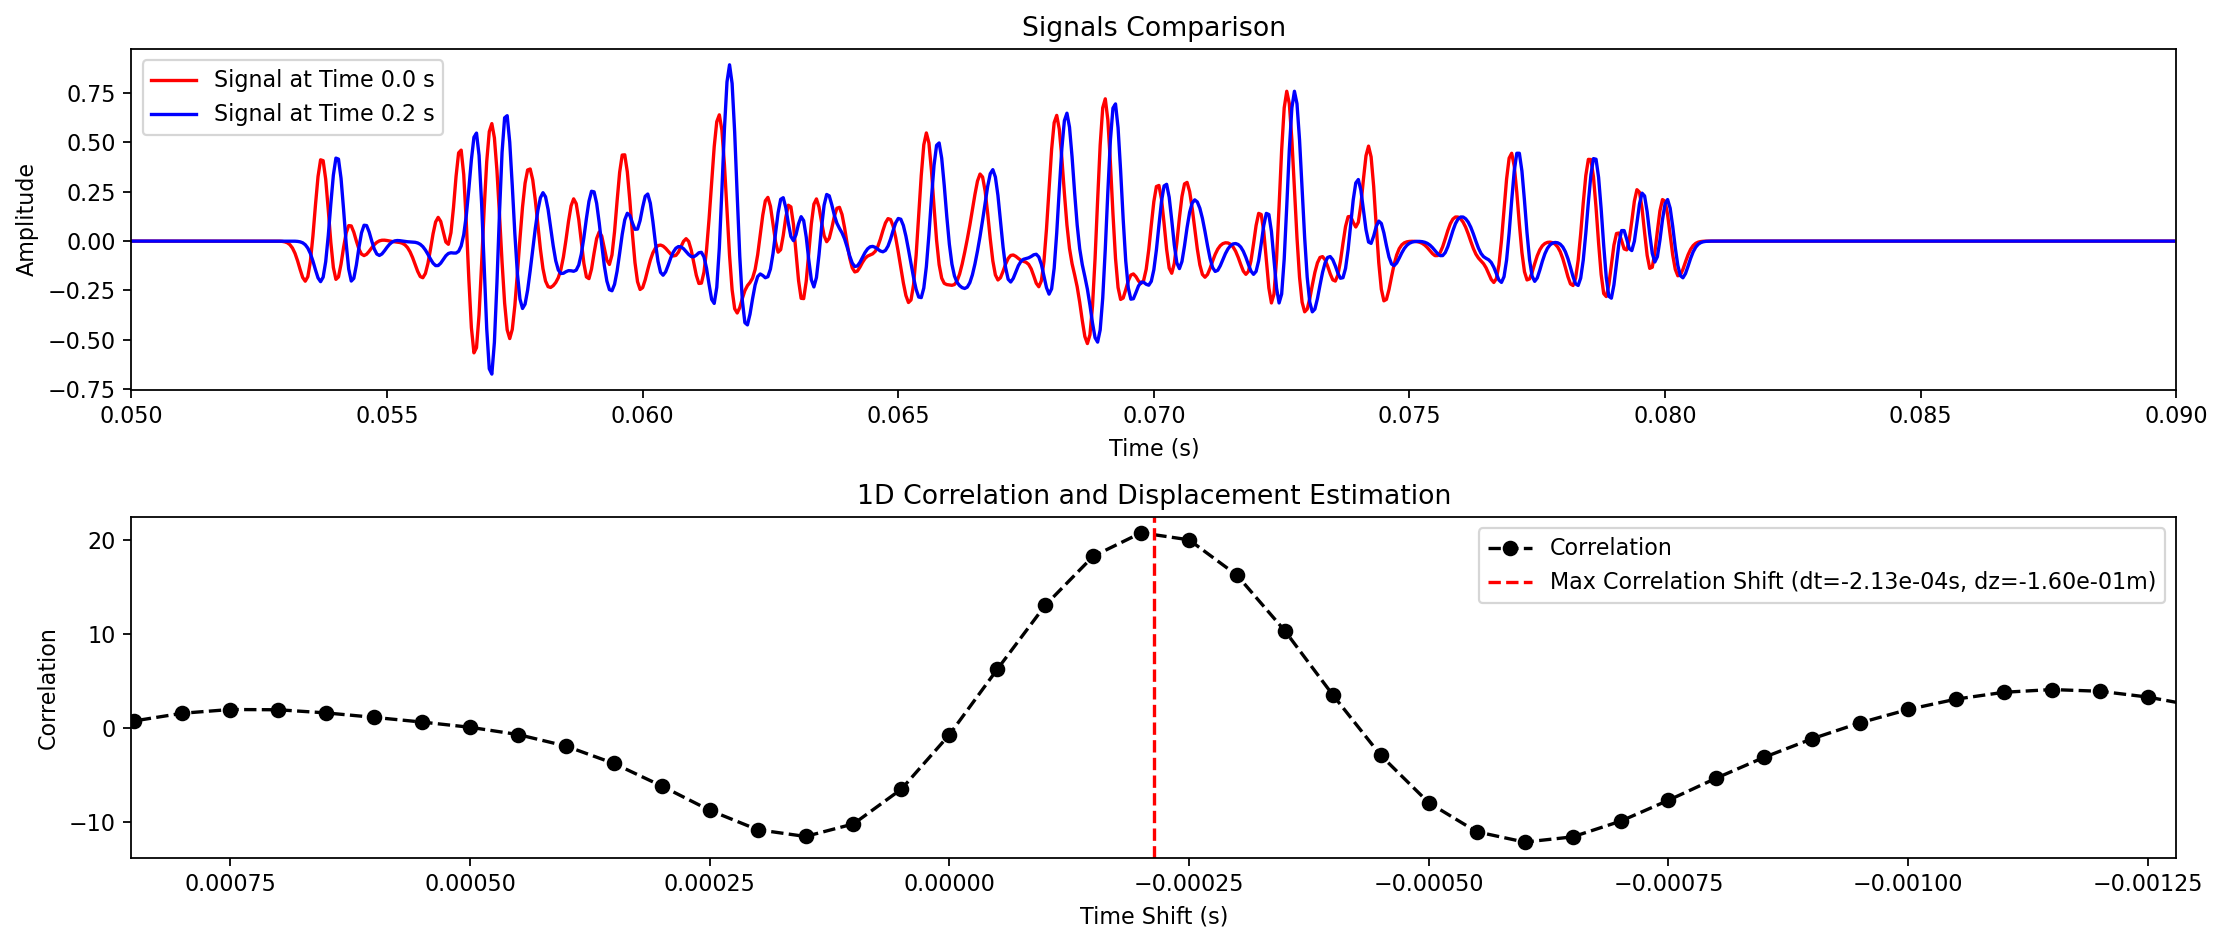

Estimated Displacement: -0.16 meters, Time Shift: -2.13e-04 seconds


In [86]:
# Reusing the find_displacement function from before, now with visualization added
def visualize_displacement_and_correlation(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound):
    dz, dt, shift_index, correlation = find_displacement(sigs, receiver_index, time_step1, time_step2, sampling_rate, speed_of_sound)
    
    # Time vectors for plotting
    t_signal = np.arange(sigs.shape[2]) / sampling_rate
    t_correlation = np.arange(-len(t_signal) + 1, len(t_signal)) / sampling_rate
    
    # Plotting the signals
    plt.figure(figsize=(14, 6), dpi=160)
    plt.subplot(2, 1, 1)
    plt.plot(t_signal, sigs[receiver_index, time_step1, :], label=f'Signal at Time {time_step1*dtsnap} s', c='red')
    plt.plot(t_signal, sigs[receiver_index, time_step2, :], label=f'Signal at Time {time_step2*dtsnap} s', c='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Signals Comparison')
    plt.legend(loc=2)
    plt.xlim(0.05, 0.09)
    
    # Plotting the correlation
    plt.subplot(2, 1, 2)
    plt.plot(t_correlation, correlation, label='Correlation', c='k', ls='--', marker='o')
    plt.axvline(x=dt, color='r', linestyle='--', label=f'Max Correlation Shift (dt={dt:.2e}s, dz={dz:.2e}m)')
    plt.xlabel('Time Shift (s)')
    plt.ylabel('Correlation')
    plt.title('1D Correlation and Displacement Estimation')
    plt.legend()
    plt.xlim(dt-5*dt, dt+5*dt)
    plt.tight_layout()
    plt.show()

    return dz, dt

# Example usage
dz, dt = visualize_displacement_and_correlation(sigs, receiver_index=0, time_step1=0, time_step2=200, sampling_rate=sampling_rate, speed_of_sound=speed_of_sound)
print(f"Estimated Displacement: {dz:.2f} meters, Time Shift: {dt:.2e} seconds")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


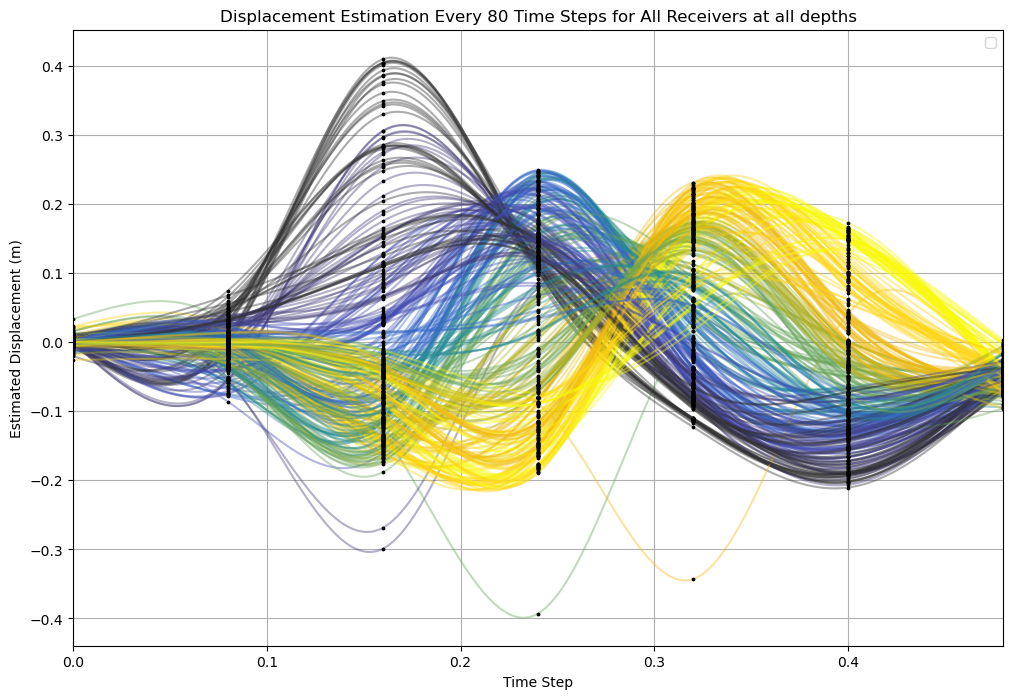

In [42]:
norm = Normalize(vmin=receiver_positions.min(), vmax=receiver_positions.max())
cmap = plt.get_cmap(cc.cm.gouldian)
    
plt.figure(figsize=(12, 8))

x = timess
xs = np.linspace(0, timess[-1], 500)
        
for d in range(matrix_time.shape[2]):
    for receiver_index in range(num_receivers):
        displacements = matrix_time[:, receiver_index, d]
    
        cs = CubicSpline(x, displacements, bc_type='natural')

        initial_x_position = receiver_positions[receiver_index]
        color = cmap(norm(initial_x_position))

        plt.plot(xs, -cs(xs, 0), linestyle='-', c=color, alpha=0.4) #, label=f'Receiver {receiver_index + 1}')
        plt.scatter(x, -displacements, c='k', marker='o', s=3, zorder=100)

plt.xlabel('Time Step')
plt.ylabel('Estimated Displacement (m)')
plt.title(f'Displacement Estimation Every {80} Time Steps for All Receivers at all depths')
plt.xlim(0, timess[-1])
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Bundle variables into a dictionary
data_to_save = {
    "receiver_positions": receiver_positions,
    "matrix_time": matrix_time,
    "timess": timess,
    "num_receivers": num_receivers,
}

# Save the dictionary to a pickle file
with open("/home/riascodc/Documents/ARF/Images/img_npy/timevsdisp.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

In [37]:
x_pos = []
t_max = []

# for depth in range(70, 104, 1): #70-104
#     for i in range(num_receivers):
#         x_pos.append(receiver_positions[i])
#         t_max.append(timess[np.argmax(-matrix_time[:, i, depth])])

for depth in range(matrix_time.shape[2]): #70-104
    for i in range(num_receivers):
        x_pos.append(receiver_positions[i])

        displacements = matrix_time[:, i, depth]
        cs = CubicSpline(x, displacements, bc_type='natural')

        t_max.append(xs[np.argmax(-cs(xs, 0))])

Text(0, 0.5, 'Travel distance [m]')

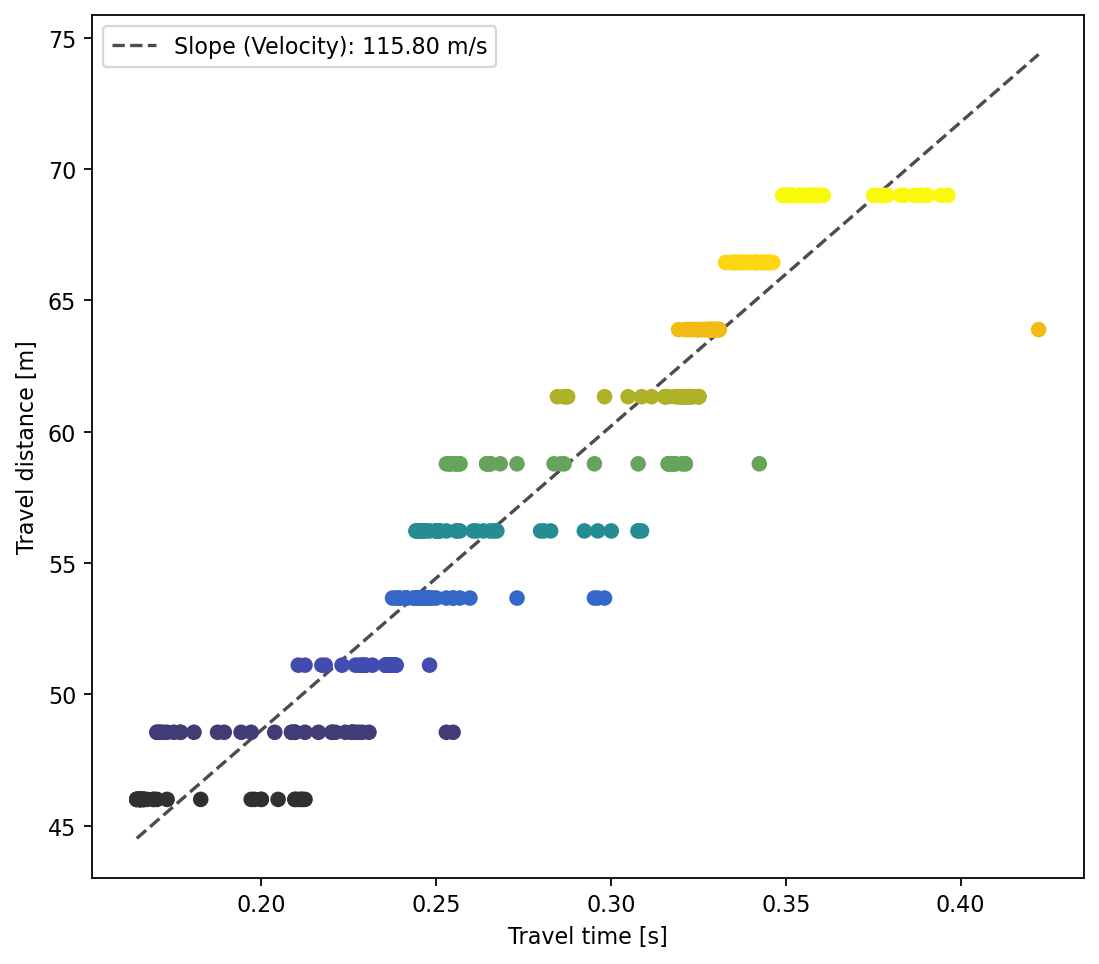

In [38]:
plt.figure(dpi=160, figsize=(8, 7))

plt.scatter(t_max, x_pos, c=x_pos, cmap=cc.cm.gouldian)

# Perform linear regression to fit a line
slope, intercept = np.polyfit(t_max, x_pos, 1)

# Now use the slope and intercept to create the line
timeaxis = np.linspace(min(t_max), max(t_max), 100)
disaxis = slope * timeaxis + intercept

plt.plot(timeaxis, disaxis, '--', alpha=0.7, c='k', zorder=0, label=f'Slope (Velocity): {slope:.2f} m/s')
plt.legend()

plt.xlabel('Travel time [s]')
plt.ylabel('Travel distance [m]')